# Question 3

### Q3.(d)

In [ ]:
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt

# Defining the algorithm function, which takes K (number of 
# mixture components), the matrix X (containing dataset) and 
# the maximum iterations to run

def load_binarydigits(filename='binarydigits.txt'):
    Y = np.loadtxt('binarydigits.txt')
    return Y

def EM_algorithm(K: int, X: np.ndarray, n_iter: int=300, epsilon: float=1e-12, min_break = 75):
    """  
    Main function fo executing the EM algorithm

    Inputs:
        - K: int, the number of mixture components
        - X: int, the matrix containing the dataset
        - n_iter: int, the maximum number of iterations
        - epsilon: float, the precision after which we can stop
            the algorithm from running.
        
    Outputs:
        - pi_k: array, size (K,1) containing all mixing proportions
        - p_kd: array, size (K,D) containing all p_kds (equivalent to 
                matrix P in problem wording)
        - log_likelihood: list, containing all the log likelihood 
                updates of the model.
    """

    # Finding dimensions of initial dataset
    N, D = np.shape(X)

    # Defining initial pi_k as an array
    # with increasing values
    pi_k = np.arange(1,K+1)
    sum_pi = np.sum(pi_k)
    pi_k = (1/sum_pi)*pi_k

    # Initializing P's values as mean of 
    # element d in all images
    p_kd = np.zeros((K, D))
    for d in range(D):
        p_kd[:, d] = (1/N)*X[:, d].sum()

    # Initializing the final 
    log_likelihood = []

    # Checking for any 0 or 1 in the values of pi 
    # and P, and if so, replacing them by very small
    # numbers. It avoids numerical instability from
    # Dividing by a 0 or log(1)=0
    for k in range(K):
        if pi_k[k] < 1e-10:
            pi_k[k] = 1e-10
        elif pi_k[k] > (1- 1e-10):
            pi_k[k] = 1- 1e-10

        for d in range(D):
            if p_kd[k,d] < 1e-10:
                p_kd[k,d] = 1e-10
            elif p_kd[k,d] > 1-1e-10:
                p_kd[k,d] = 1-1e-10
    
    # Loop of the EM algorithm, which will stop when the 
    # max number of iterations will be reached OR when the 
    # updates won't have a difference superior to epsilon
    for i in range(n_iter):

        # Calculating the responsibilities (E-step)
        r_nk = E_step(X, pi_k, p_kd, K)

        # Calculating the new pi and P values (M-Step)
        pi_k, p_kd = M_step(X, r_nk)

        # Checking for invalid values to avoid numerical
        # instability
        for k in range(K):
            if pi_k[k] < 1e-10:
                pi_k[k] = 1e-10
            elif pi_k[k] > (1- 1e-10):
                pi_k[k] = 1- 1e-10   
            for d in range(D):
                if p_kd[k,d] < 1e-10:
                    p_kd[k,d] = 1e-10
                elif p_kd[k,d] > 1-1e-10:
                    p_kd[k,d] = 1-1e-10

        # Calculating the new log likelihood, given the calculated
        # optimal parameters and storing it in the list
        log_like = log_likelihood_EM(X, pi_k, p_kd, r_nk)
        log_likelihood.append(log_like)

        # Breaking the loop if the updates don't bring any change
        if i > min_break and abs(log_likelihood[-1] - log_likelihood[-2]) < epsilon:
            break

    return pi_k, p_kd, log_likelihood

def E_step(X: np.ndarray, pi_k, p_kd, K):
    """ 
    Calculating the E-step of the algorithm, using the equations found earlier

    Inputs: 
    - X: np.ndarray, shape (N,D), contains initial data
    - pi_k: list, shape(K,), contains current pi values for each mixture
    - p_kd: array, shape(K, D), contains current probabilities
    - K: int, number of models in the mixture

    Outputs:
    - r_nk: np.ndarray, shape(N,K), contains responsibilities of each model
    """
    # Defining the values of N, being number of rows in dataset
    N, _ = np.shape(X)

    # Initializing the responsibilities matrix
    log_r_nk = np.zeros((N, K))

    # Reuniting the different rows of pi_k 
    # as a single row
    log_pi_k = np.log(pi_k).ravel()

    # Calculating the logs of each responsibility
    log_r_nk = log_pi_k + (X @ np.log(p_kd.T)) + ((1 - X) @ np.log(1 - p_kd.T))

    # Normalizing the logs of responsibilities
    log_r_nk = log_r_nk - logsumexp(log_r_nk, axis=1, keepdims=True)

    # Returning to the non-log domain, by calculating the exponential
    # of the responsibilities
    r_nk = np.exp(log_r_nk)

    return r_nk

def M_step(X: np.ndarray, r_nk):
    """ 
    Calculates the M-step of the EM algorithm, using the equations defined in report

    Inputs: 
    - X: np.ndarray, shape (N,D), contains initial data
    - r_nk: array, shape (N, K), responsibilities calculated of each model on
                                    each data point
    Outputs:
    - pi_k: list, shape (K,), contains current pi values for each mixture
    - P: array, shape (K, D), contains current probabilities
    """

    N, D = np.shape(X)
    K = np.shape(r_nk)[1]

    # Verifying the validity of the values
    # of the responsibilities
    for n in range(N):
        for k in range(K):
            if r_nk[n,k] < 1e-10:
                r_nk[n, k] = 1e-10
            elif r_nk[n,k] > (1-1e-10):
                r_nk[n,k] = 1-1e-10

    # Calculating the updates of the parameters
    pi_k = (1/N)*np.sum(r_nk, axis=0)
    log_p_kd = np.log(r_nk.T @ X) - np.log(r_nk.sum(axis=0)[:, np.newaxis])
    p_kd = np.exp(log_p_kd)

    # Verifying the validity of the values
    # of the newly calculated parameters (in pi and P)
    for k in range(K):
            if pi_k[k] < 1e-10:
                pi_k[k] = 1e-10
            elif pi_k[k] > (1- 1e-10):
                pi_k[k] = 1- 1e-10   
            for d in range(D):
                if p_kd[k,d] < 1e-10:
                    p_kd[k,d] = 1e-10
                elif p_kd[k,d] > 1-1e-10:
                    p_kd[k,d] = 1-1e-10

    return pi_k, p_kd


def log_likelihood_EM(X, pi_k, p_kd, r_nk):
    """
    Calculating the log likelihood of the data being given the parameters of the mixture model

    Inputs:
    - X: np.ndarray, shape (N,D), contains initial data
    - pi_k: list, shape (K,), contains current pi values for each mixture
    - p_kd: array, shape (K, D), contains current probabilities
    - r_nk: array, shape (N, K), responsibilities calculated of each model on
                                    each data point
    Outputs:
    - log_likelihood: float, log likelihood probability calculated
    """

    # Calculating N, D, K and initializing the value of the log likelihood
    N, D = np.shape(X)
    K = np.shape(pi_k)[0]
    log_likelihood = 0

    # Looping through the r_nk dimensions, since there will be as many elements to add
    # as there is responsibilities
    for n in range(N):
        for k in range(K):

            # Calculating the log of element k in pi matrix
            log_pi = np.log(pi_k[k])

            # Calculating P(x \vert s=k, pi, P), the main element in the calculation
            log_px_given_k = np.sum(X[n] * np.log(p_kd[k]) + (1 - X[n]) * np.log(1 - p_kd[k]))

            # Weighting the log of probabilities by the responsibilities, and adding them to the
            # log likelihood.
            log_rnk_contribution = r_nk[n,k] * (log_pi + log_px_given_k)
            log_likelihood += log_rnk_contribution

    return log_likelihood


def plot_EM(log_likelihoods, pi_k, p_kd, K, save_like=False, save_prob=False):
    """ 
    Plots the EM results obtained
    """

    # Plotting the obtained log likelihoods as a function of the iterations
    plt.figure(figsize=(10,4))
    plt.plot(log_likelihoods)
    plt.xlabel("Iteration")
    plt.ylabel("Log-Likelihood")
    plt.title(f"Log-Likelihood in the EM Algorithm for K = {K}")
    plt.grid()
    if save_like:
        plt.savefig(f'Q3/Loglikelihood_{K}.png', format="png", dpi=300, bbox_inches="tight")
    plt.show()


    # Plotting the mixture components probabilities as heat maps
    K, D = p_kd.shape
    image_size = int(np.sqrt(D))
    figs, axs = plt.subplots(1, K, figsize=(4*K, 4))
    figs.suptitle(f"Mixture components probabilities for K = {K})", fontsize=14)
    for i in range(K):
        ax = axs[i] if K > 1 else axs 
        ax.imshow(p_kd[i].reshape((image_size, image_size)), cmap='viridis')
        ax.set_title(f"pi: {pi_k[i]:.2f}", fontsize=10)
        ax.axis('off')
    if save_prob:
        plt.savefig(f'Q3/prob_{K}.png', format="png", dpi=300, bbox_inches="tight")
    plt.show()


def main():
    Ks: list = [2, 3, 4, 7, 10]
    Y = load_binarydigits()

    for K in Ks:
        print("=== EM Algorithm for K =", K, " ===")
        pi_k, p_kd, log_likelihoods = EM_algorithm(K, Y, n_iter=75, epsilon=1e-6)
        print("For K=", K, ", \n pi_k = ", pi_k, "\n p_kd = ", p_kd, "\n and log_likelihoods = ", log_likelihoods)
        plot_EM(log_likelihoods, pi_k, p_kd, K)


main()

### Q3.(e) - Same code as before, but it generates random initial parameters

Additionally, it also displays the initial random matrix P to be compared with final one

=== EM Algorithm for K = 2  ===
[0.767745570476548, 0.1319176582653624]


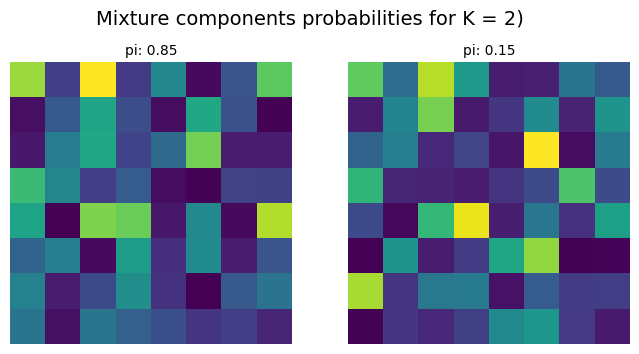

/var/folders/rr/8jw5g3w50bl6mqztp2dkdtf80000gn/T/ipykernel_78437/2806250458.py:191: RuntimeWarning: divide by zero encountered in log
  log_p_kd = np.log(r_nk.T @ X) - np.log(r_nk.sum(axis=0)[:, np.newaxis])


For K= 2 , 
 pi_k =  [0.41963514 0.58036486] 
 p_kd =  [[1.00000000e-10 2.38219251e-02 7.14508885e-02 2.61458015e-01
  5.71763142e-01 7.14898777e-01 5.47416207e-01 1.66123411e-01
  1.00000000e-10 7.14670870e-02 3.56778916e-01 6.90294155e-01
  7.61787559e-01 7.61741993e-01 8.81481257e-01 4.52701796e-01
  7.14690360e-02 2.85944504e-01 6.66494882e-01 5.23513032e-01
  2.38185828e-01 2.14327970e-01 6.19419533e-01 8.81477187e-01
  3.09133512e-01 7.61914055e-01 6.66472875e-01 2.13766007e-01
  4.69576644e-02 2.31986189e-02 5.47875476e-01 8.09996828e-01
  6.90395523e-01 8.09515486e-01 1.66736323e-01 2.37589797e-02
  1.00000000e-10 2.37519575e-01 8.33219737e-01 5.00403085e-01
  9.52452623e-01 6.90971387e-01 1.00000000e-10 1.00000000e-10
  1.66664115e-01 6.18732691e-01 7.38080580e-01 2.14448458e-01
  8.10016395e-01 8.09545748e-01 4.04466761e-01 6.19357950e-01
  8.80839447e-01 8.33330325e-01 2.38303141e-01 1.00000000e-10
  2.38092314e-01 8.33831372e-01 1.00000000e+00 9.04682330e-01
  3.80633646e-0

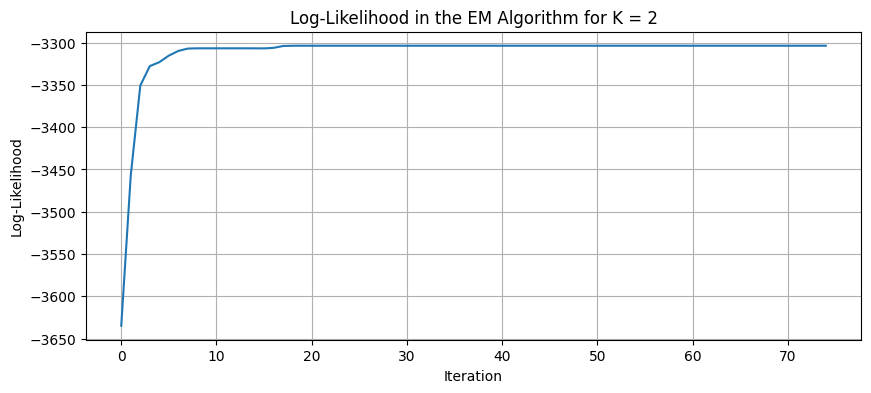

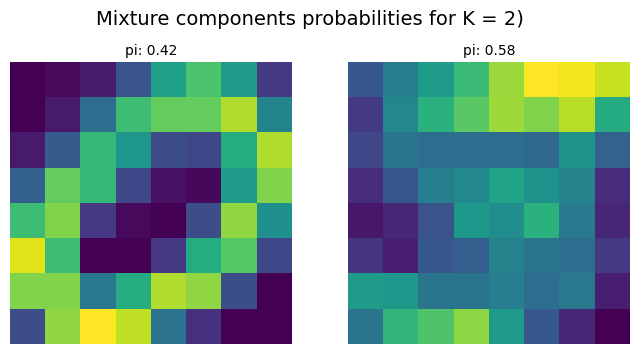

=== EM Algorithm for K = 3  ===
[0.5576695240506597, 0.8464086233475034, 0.16275230479984093]


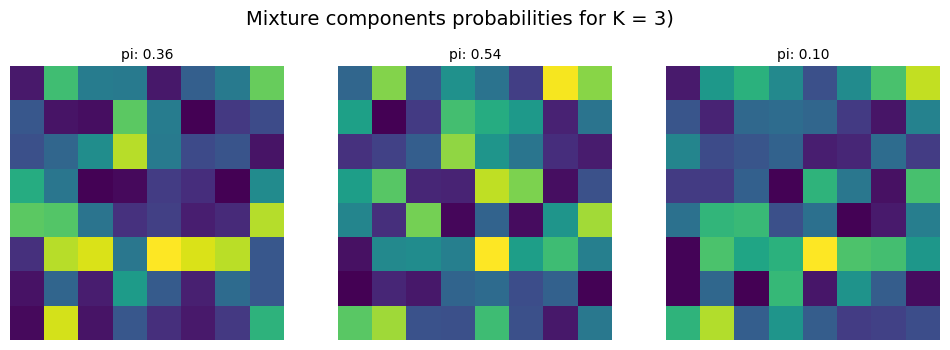

For K= 3 , 
 pi_k =  [0.8900008 0.0699992 0.04     ] 
 p_kd =  [[1.46067285e-01 2.24718899e-01 2.92134569e-01 4.38201854e-01
  6.40448863e-01 7.75280622e-01 6.51685706e-01 4.60674642e-01
  7.86516148e-02 2.35955315e-01 4.26966379e-01 6.40449333e-01
  7.41573262e-01 7.07865431e-01 7.86516622e-01 4.94381579e-01
  1.12359920e-01 3.03370984e-01 5.05617523e-01 4.04494913e-01
  2.24719797e-01 1.91011068e-01 5.16853468e-01 5.84269138e-01
  1.91011535e-01 5.05617523e-01 5.16853892e-01 2.69663577e-01
  2.02247907e-01 2.13483844e-01 4.83146053e-01 4.49437799e-01
  3.48314764e-01 4.26966379e-01 1.46068179e-01 1.79775547e-01
  1.91011072e-01 4.15730442e-01 5.61798146e-01 2.92134569e-01
  5.28089413e-01 3.37078349e-01 6.74156698e-02 1.12359450e-01
  3.14606459e-01 4.83146053e-01 4.94382477e-01 1.79775123e-01
  5.84269566e-01 5.73033197e-01 3.25842879e-01 4.94381578e-01
  6.06741456e-01 5.50561731e-01 2.92135047e-01 4.49437799e-02
  2.35954848e-01 6.62921181e-01 8.08988465e-01 8.20224881e-01
  4.269

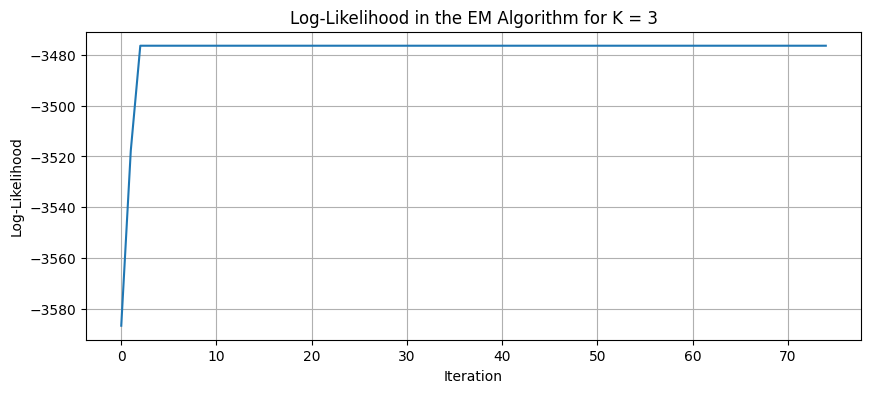

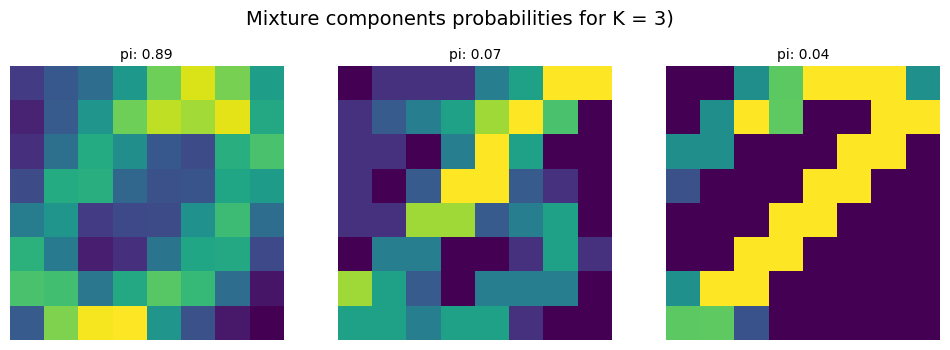

=== EM Algorithm for K = 4  ===
[0.2167543015137814, 0.0879388643820278, 0.05468608007327935, 0.923873434190706]


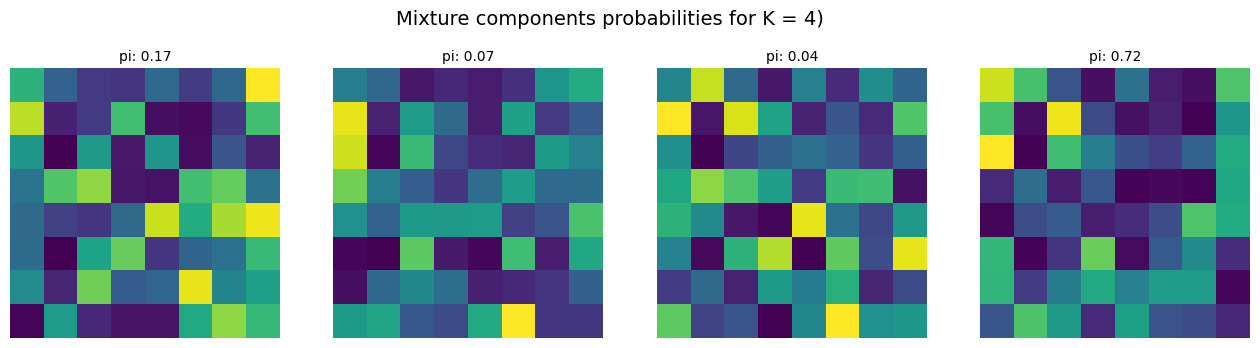

For K= 4 , 
 pi_k =  [0.03       0.53035749 0.02       0.41964251] 
 p_kd =  [[4.33333332e-10 6.99999998e-10 6.66666666e-01 6.66666666e-01
  6.66666667e-01 9.99999999e-01 6.66666667e-01 6.66666666e-01
  2.66666666e-10 3.33333333e-01 3.33333334e-01 2.13333333e-09
  3.33333334e-01 3.33333334e-01 2.63333333e-09 1.60000000e-09
  4.33333332e-10 6.66666666e-01 6.66666666e-01 3.33333334e-01
  9.99999998e-01 3.33333333e-01 1.66666666e-09 1.73333333e-09
  6.33333332e-10 6.66666666e-01 6.66666666e-01 6.66666665e-01
  3.33333333e-01 6.66666665e-01 6.66666666e-01 1.33333333e-09
  1.06666666e-09 3.33333334e-01 6.33333332e-10 3.33333333e-01
  3.33333333e-01 3.33333333e-01 6.66666666e-01 3.33333333e-01
  1.56666666e-09 1.10000000e-09 4.33333332e-10 4.66666665e-10
  9.33333331e-10 1.46666666e-09 6.66666666e-01 9.99999997e-01
  6.66666666e-01 1.96666666e-09 1.16666666e-09 1.46666666e-09
  1.90000000e-09 1.73333333e-09 9.99999998e-01 9.99999997e-01
  3.33333333e-01 9.99999999e-01 9.99999999e-01 9.999999

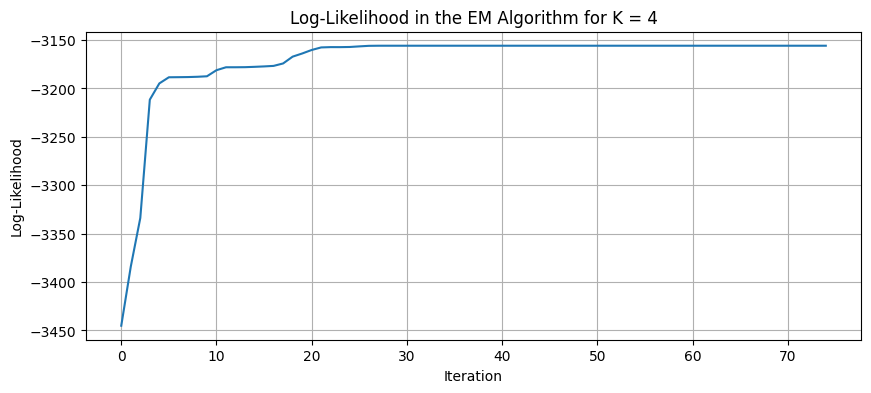

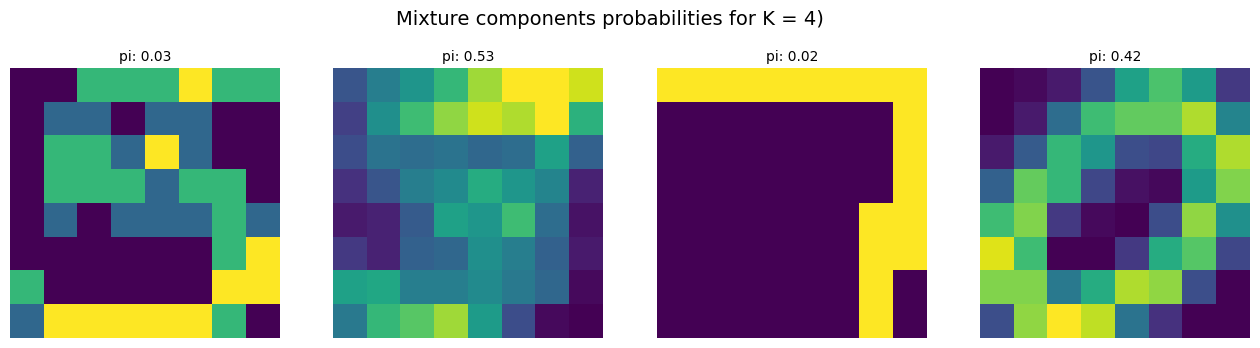

=== EM Algorithm for K = 7  ===
[0.10740275115413356, 0.28430410164965103, 0.5244584971089661, 0.09719302095173299, 0.9204049683853961, 0.006077131848305495, 0.30063071500198035]


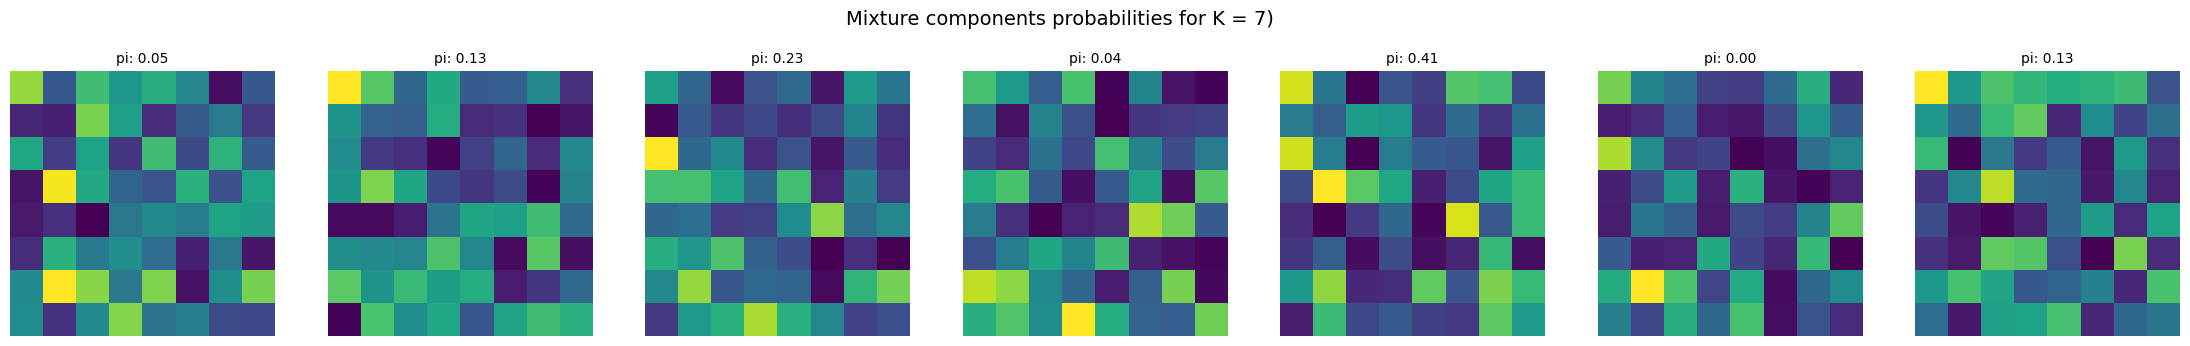

For K= 7 , 
 pi_k =  [0.005      0.005      0.03999999 0.21995044 0.16993727 0.33008259
 0.23002972] 
 p_kd =  [[2.59999995e-09 4.19999992e-09 9.99999986e-01 9.99999989e-01
  9.99999993e-01 9.99999995e-01 9.99999994e-01 9.99999990e-01
  1.59999997e-09 4.99999990e-09 9.99999989e-01 1.27999997e-08
  1.43999997e-08 1.39999997e-08 1.57999997e-08 9.59999981e-09
  2.59999995e-09 9.99999986e-01 9.99999989e-01 7.79999985e-09
  9.99999985e-01 4.99999990e-09 9.99999980e-09 1.03999998e-08
  3.79999992e-09 9.99999989e-01 9.99999990e-01 9.99999986e-01
  9.99999986e-01 9.99999985e-01 9.99999989e-01 7.99999984e-09
  6.39999987e-09 7.79999985e-09 3.79999992e-09 5.19999990e-09
  4.59999991e-09 7.99999984e-09 9.99999991e-01 5.19999990e-09
  9.39999981e-09 6.59999987e-09 2.59999995e-09 2.79999994e-09
  5.59999989e-09 8.79999983e-09 9.99999990e-01 9.99999983e-01
  1.19999998e-08 1.17999998e-08 6.99999986e-09 8.79999983e-09
  1.13999998e-08 1.03999998e-08 9.99999986e-01 9.99999981e-01
  5.59999989e-09 9.99

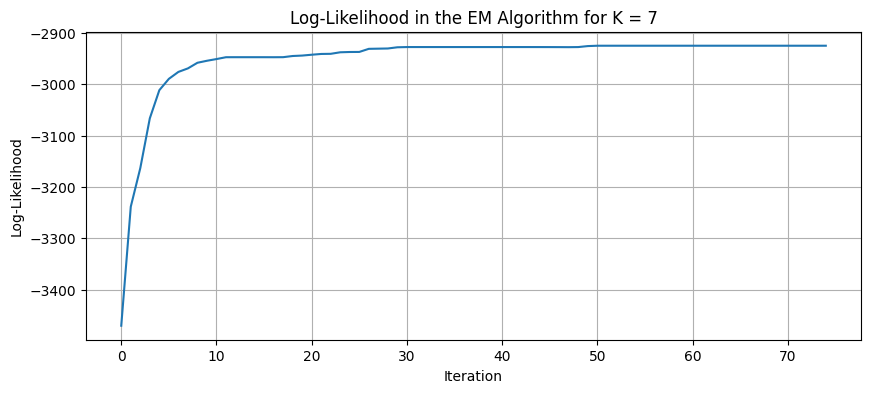

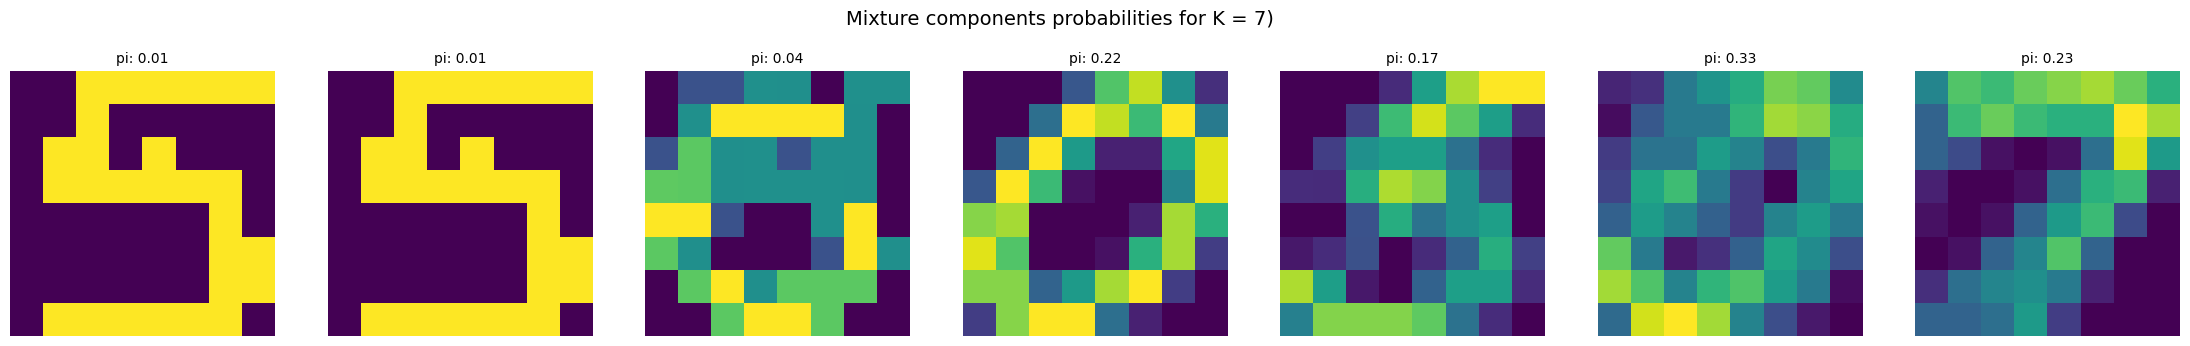

=== EM Algorithm for K = 10  ===
[0.46437420847086386, 0.6541702070411636, 0.8674568587142728, 0.29308879476540883, 0.023417513902583842, 0.45171892103618516, 0.256329970420743, 0.6852226248896819, 0.26735059798769867, 0.5433920631091967]


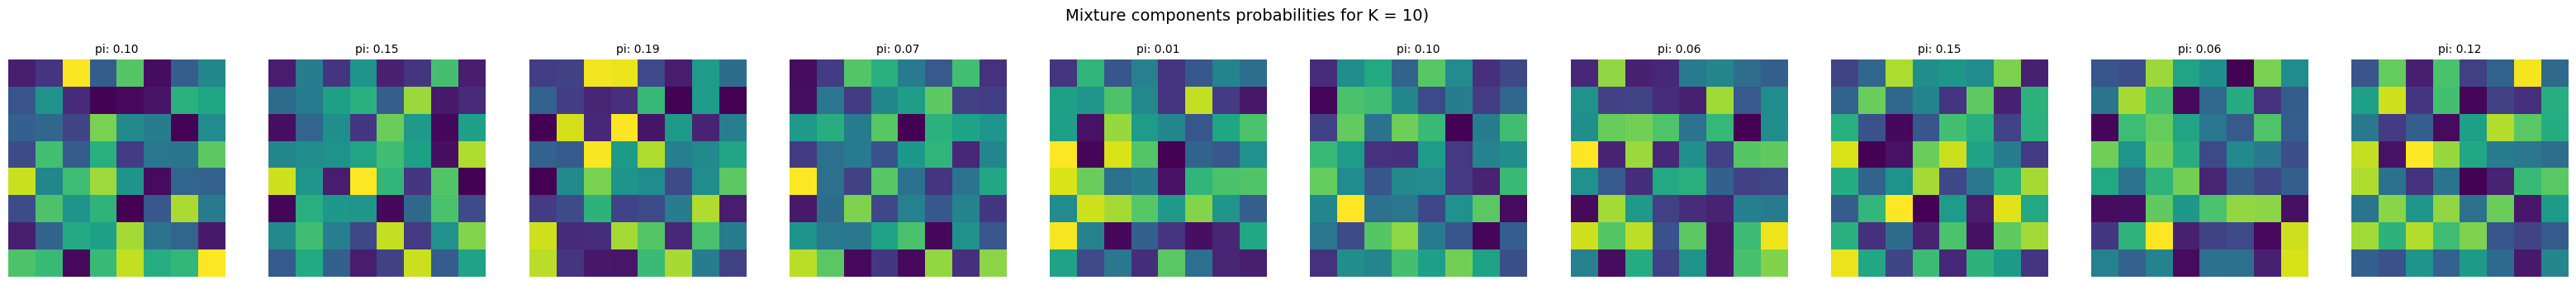

For K= 10 , 
 pi_k =  [0.07999478 0.19060355 0.28939646 0.05       0.15000521 0.07
 0.14       0.01       0.01       0.01      ] 
 p_kd =  [[1.62510597e-10 2.62517118e-10 3.62523639e-10 5.37535052e-10
  6.24975574e-01 8.74992962e-01 7.49984820e-01 6.25040758e-10
  1.00006521e-10 3.12520379e-10 5.62536682e-10 1.00000000e+00
  1.00000000e+00 5.00002769e-01 1.00000000e+00 6.24976674e-01
  1.62510597e-10 3.75024455e-10 9.99999999e-01 7.49984820e-01
  1.25008138e-01 1.25008146e-01 3.74995722e-01 9.99999999e-01
  2.37515488e-10 9.99999999e-01 9.99999999e-01 3.87525270e-10
  3.62523639e-10 3.12520379e-10 2.49953648e-01 9.99999999e-01
  6.24978086e-01 9.99999999e-01 2.37515488e-10 3.25021194e-10
  2.87518749e-10 5.00032606e-10 9.99999999e-01 6.25039315e-01
  9.99999999e-01 4.99968527e-01 1.62510597e-10 1.75011412e-10
  3.50022824e-10 4.99967423e-01 9.99999999e-01 2.12513858e-10
  9.99999999e-01 4.99968528e-01 4.37528530e-10 3.74987989e-01
  9.99999999e-01 9.99999999e-01 3.62523639e-10 1.000000

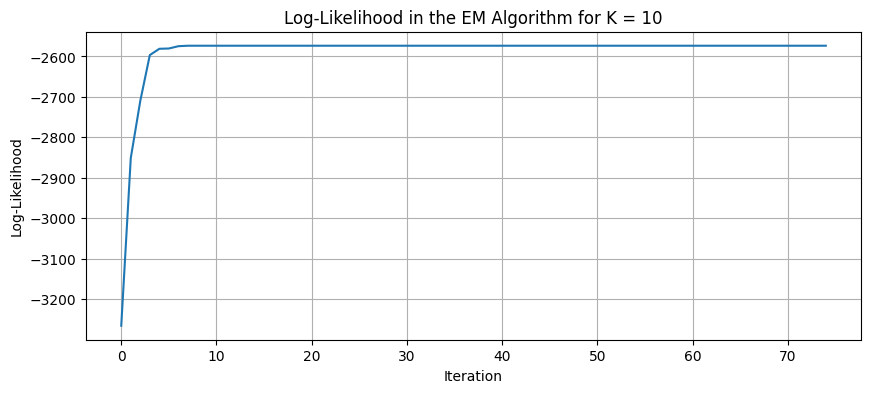

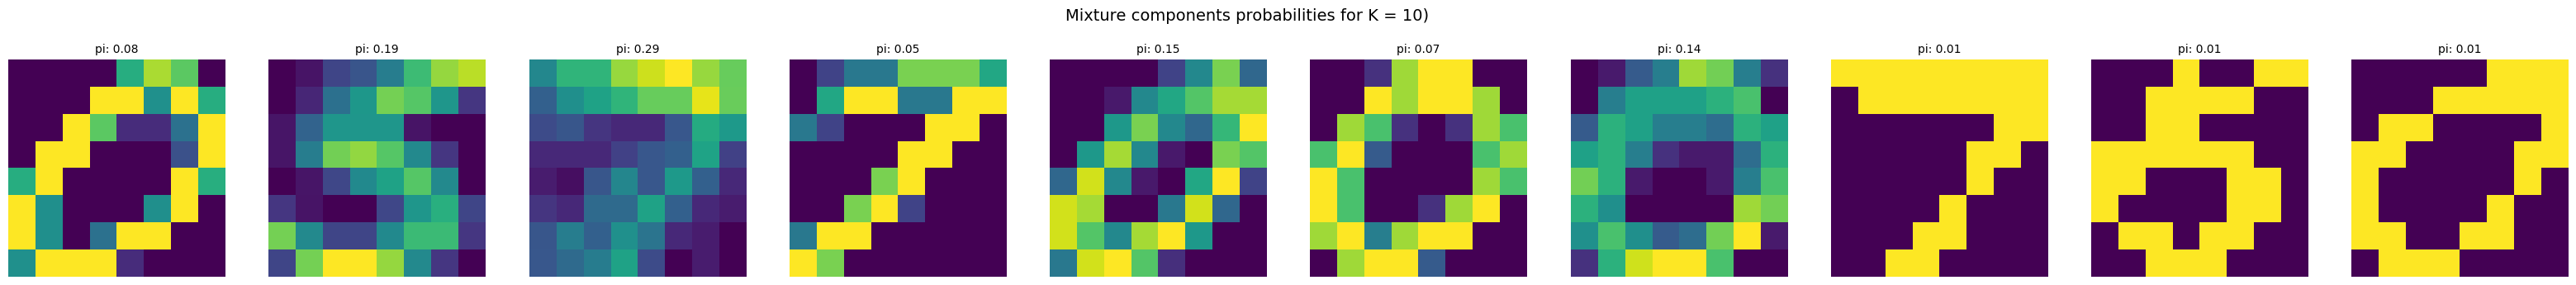

In [ ]:
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import random

# Defining the algorithm function, which takes K (number of 
# mixture components), the matrix X (containing dataset) and 
# the maximum iterations to run

def EM_algorithm(K: int, X: np.ndarray, n_iter: int=300, epsilon: float=1e-12, min_break = 75):
    """  
    Main function fo executing the EM algorithm

    Inputs:
        - K: int, the number of mixture components
        - X: int, the matrix containing the dataset
        - n_iter: int, the maximum number of iterations
        - epsilon: float, the precision after which we can stop
            the algorithm from running.
        
    Outputs:
        - pi_k: array, size (K,1) containing all mixing proportions
        - p_kd: array, size (K,D) containing all p_kds (equivalent to 
                matrix P in problem wording)
        - log_likelihood: list, containing all the log likelihood 
                updates of the model.
    """

    # Finding dimensions of initial dataset
    N, D = np.shape(X)

    # Defining initial pi_k as an array
    # with increasing values
    #pi_k = np.arange(1,K+1)
    #sum_pi = np.sum(pi_k)
    #pi_k = (1/sum_pi)*pi_k

    # Initializing random values instead
    prop = []
    for _ in range(K):
        prop.append(random.random())
    print(prop)
    list_pi = prop/np.sum(prop)
    pi_k = np.array([i for i in list_pi])

    # Initializing P's values as mean of 
    # element d in all images
    p_kd = np.zeros((K, D))
    for k in range(K):
        for d in range(D):
            p_kd[k,d] = random.random()
    # Normalizing on the right axis
    for d in range(D):
        p_kd[:, d] = p_kd[:, d]*(np.sum(p_kd[:, d]))

    if False:
        # Plotting the mixture components probabilities as heat maps
        K, D = p_kd.shape
        image_size = int(np.sqrt(D))
        figs, axs = plt.subplots(1, K, figsize=(4*K, 4))
        figs.suptitle(f"Mixture components probabilities for K = {K})", fontsize=14)
        for i in range(K):
            ax = axs[i] if K > 1 else axs 
            ax.imshow(p_kd[i].reshape((image_size, image_size)), cmap='viridis')
            ax.set_title(f"pi: {pi_k[i]:.2f}", fontsize=10)
            ax.axis('off')
    
        plt.savefig(f'Q3/prob_random_initial_{K}.png', format="png", dpi=300, bbox_inches="tight")
        plt.show()

    # Initializing the final 
    log_likelihood = []

    # Checking for any 0 or 1 in the values of pi 
    # and P, and if so, replacing them by very small
    # numbers. It avoids numerical instability from
    # Dividing by a 0 or log(1)=0
    for k in range(K):
        if pi_k[k] < 1e-10:
            pi_k[k] = 1e-10
        elif pi_k[k] > (1- 1e-10):
            pi_k[k] = 1- 1e-10

        for d in range(D):
            if p_kd[k,d] < 1e-10:
                p_kd[k,d] = 1e-10
            elif p_kd[k,d] > 1-1e-10:
                p_kd[k,d] = 1-1e-10
    
    # Loop of the EM algorithm, which will stop when the 
    # max number of iterations will be reached OR when the 
    # updates won't have a difference superior to epsilon
    for i in range(n_iter):

        # Calculating the responsibilities (E-step)
        r_nk = E_step(X, pi_k, p_kd, K)

        # Calculating the new pi and P values (M-Step)
        pi_k, p_kd = M_step(X, r_nk)

        # Checking for invalid values to avoid numerical
        # instability
        for k in range(K):
            if pi_k[k] < 1e-10:
                pi_k[k] = 1e-10
            elif pi_k[k] > (1- 1e-10):
                pi_k[k] = 1- 1e-10   
            for d in range(D):
                if p_kd[k,d] < 1e-10:
                    p_kd[k,d] = 1e-10
                elif p_kd[k,d] > 1-1e-10:
                    p_kd[k,d] = 1-1e-10

        # Calculating the new log likelihood, given the calculated
        # optimal parameters and storing it in the list
        log_like = log_likelihood_EM(X, pi_k, p_kd, r_nk)
        log_likelihood.append(log_like)

        # Breaking the loop if the updates don't bring any change
        if i > min_break and abs(log_likelihood[-1] - log_likelihood[-2]) < epsilon:
            break

    return pi_k, p_kd, log_likelihood

def E_step(X: np.ndarray, pi_k, p_kd, K):
    """ 
    Calculating the E-step of the algorithm, using the equations found earlier

    Inputs: 
    - X: np.ndarray, shape (N,D), contains initial data
    - pi_k: list, shape(K,), contains current pi values for each mixture
    - p_kd: array, shape(K, D), contains current probabilities
    - K: int, number of models in the mixture

    Outputs:
    - r_nk: np.ndarray, shape(N,K), contains responsibilities of each model
    """
    # Defining the values of N, being number of rows in dataset
    N, _ = np.shape(X)

    # Initializing the responsibilities matrix
    log_r_nk = np.zeros((N, K))

    # Reuniting the different rows of pi_k 
    # as a single row
    log_pi_k = np.log(pi_k).ravel()

    # Calculating the logs of each responsibility
    log_r_nk = log_pi_k + (X @ np.log(p_kd.T)) + ((1 - X) @ np.log(1 - p_kd.T))

    # Normalizing the logs of responsibilities
    log_r_nk = log_r_nk - logsumexp(log_r_nk, axis=1, keepdims=True)

    # Returning to the non-log domain, by calculating the exponential
    # of the responsibilities
    r_nk = np.exp(log_r_nk)

    return r_nk

def M_step(X: np.ndarray, r_nk):
    """ 
    Calculates the M-step of the EM algorithm, using the equations defined in report

    Inputs: 
    - X: np.ndarray, shape (N,D), contains initial data
    - r_nk: array, shape (N, K), responsibilities calculated of each model on
                                    each data point
    Outputs:
    - pi_k: list, shape (K,), contains current pi values for each mixture
    - P: array, shape (K, D), contains current probabilities
    """

    N, D = np.shape(X)
    K = np.shape(r_nk)[1]

    # Verifying the validity of the values
    # of the responsibilities
    for n in range(N):
        for k in range(K):
            if r_nk[n,k] < 1e-10:
                r_nk[n, k] = 1e-10
            elif r_nk[n,k] > (1-1e-10):
                r_nk[n,k] = 1-1e-10

    # Calculating the updates of the parameters
    pi_k = (1/N)*np.sum(r_nk, axis=0)
    log_p_kd = np.log(r_nk.T @ X) - np.log(r_nk.sum(axis=0)[:, np.newaxis])
    p_kd = np.exp(log_p_kd)

    # Verifying the validity of the values
    # of the newly calculated parameters (in pi and P)
    for k in range(K):
            if pi_k[k] < 1e-10:
                pi_k[k] = 1e-10
            elif pi_k[k] > (1- 1e-10):
                pi_k[k] = 1- 1e-10   
            for d in range(D):
                if p_kd[k,d] < 1e-10:
                    p_kd[k,d] = 1e-10
                elif p_kd[k,d] > 1-1e-10:
                    p_kd[k,d] = 1-1e-10

    return pi_k, p_kd


def log_likelihood_EM(X, pi_k, p_kd, r_nk):
    """
    Calculating the log likelihood of the data being given the parameters of the mixture model

    Inputs:
    - X: np.ndarray, shape (N,D), contains initial data
    - pi_k: list, shape (K,), contains current pi values for each mixture
    - p_kd: array, shape (K, D), contains current probabilities
    - r_nk: array, shape (N, K), responsibilities calculated of each model on
                                    each data point
    Outputs:
    - log_likelihood: float, log likelihood probability calculated
    """

    # Calculating N, D, K and initializing the value of the log likelihood
    N, D = np.shape(X)
    K = np.shape(pi_k)[0]
    log_likelihood = 0

    # Looping through the r_nk dimensions, since there will be as many elements to add
    # as there is responsibilities
    for n in range(N):
        for k in range(K):

            # Calculating the log of element k in pi matrix
            log_pi = np.log(pi_k[k])

            # Calculating P(x \vert s=k, pi, P), the main element in the calculation
            log_px_given_k = np.sum(X[n] * np.log(p_kd[k]) + (1 - X[n]) * np.log(1 - p_kd[k]))

            # Weighting the log of probabilities by the responsibilities, and adding them to the
            # log likelihood.
            log_rnk_contribution = r_nk[n,k] * (log_pi + log_px_given_k)
            log_likelihood += log_rnk_contribution

    return log_likelihood


def plot_EM(log_likelihoods, pi_k, p_kd, K, save_like=False, save_prob=False):
    """ 
    Plots the EM results obtained
    """

    # Plotting the obtained log likelihoods as a function of the iterations
    plt.figure(figsize=(10,4))
    plt.plot(log_likelihoods)
    plt.xlabel("Iteration")
    plt.ylabel("Log-Likelihood")
    plt.title(f"Log-Likelihood in the EM Algorithm for K = {K}")
    plt.grid()
    if save_like:
        plt.savefig(f'Q3/Loglikelihood_random_{K}.png', format="png", dpi=300, bbox_inches="tight")
    plt.show()


    # Plotting the mixture components probabilities as heat maps
    K, D = p_kd.shape
    image_size = int(np.sqrt(D))
    figs, axs = plt.subplots(1, K, figsize=(4*K, 4))
    figs.suptitle(f"Mixture components probabilities for K = {K})", fontsize=14)
    for i in range(K):
        ax = axs[i] if K > 1 else axs 
        ax.imshow(p_kd[i].reshape((image_size, image_size)), cmap='viridis')
        ax.set_title(f"pi: {pi_k[i]:.2f}", fontsize=10)
        ax.axis('off')
    if save_prob:
        plt.savefig(f'Q3/prob_random_{K}.png', format="png", dpi=300, bbox_inches="tight")
    plt.show()


def main():
    Ks: list = [2, 3, 4, 7, 10]
    Y = load_binarydigits()

    for K in Ks:
        print("=== EM Algorithm for K =", K, " ===")
        pi_k, p_kd, log_likelihoods = EM_algorithm(K, Y, n_iter=75, epsilon=1e-6)
        print("For K=", K, ", \n pi_k = ", pi_k, "\n p_kd = ", p_kd, "\n and log_likelihoods = ", log_likelihoods)
        plot_EM(log_likelihoods, pi_k, p_kd, K, True, True)


main()